[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jolin-io/KI2022-tutorial-universal-differential-equations/main?filepath=03%20introduction%20to%20neural%20differential%20equations.ipynb)

<a href="https://www.jolin.io" target="_blank" rel="noreferrer noopener">
<img src="https://www.jolin.io/assets/Jolin/Jolin-Banner-Website-v1.1-darkmode.webp">
</a>

# Introduction to Universal Differential Equations in <img height="60px" style='height:60px;display:inline;' alt="Julia" src="https://julialang.org/assets/infra/logo.svg">

The term Universal Differential Equations was introduced in the paper [Universal Differential Equations for Scientific
Machine Learning by Rackauckas et. al. 2021](https://arxiv.org/pdf/2001.04385.pdf)

It is about one using machine learning as part of differential equation problems. As such it is one way of combining scientific model-based approaches with machine learning techniques, which is often named scientific machine learning.

Here an overview over the scientific machine learning ecosystem as described in the UDE paper:
![](./assets/overview_sciml_ecosystem.png)

This is a huge ecosystem. For today we focuse mostly on the last layer of implementing Differential Equations which depend on Neural Networks directly.

In [1]:
import DifferentialEquations, Plots, Lux, Zygote, DiffEqSensitivity, Optimisers, Random, Statistics

rng = Random.MersenneTwister()
Random.seed!(rng, 12345)

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423
┌ Info: Precompiling DiffEqSensitivity [41bf760c-e81c-5289-8e54-58b1f1f8abe2]
└ @ Base loading.jl:1423


Random.MersenneTwister(12345)

# DifferentialEquations.jl

Example [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations): Population of rabbits and foxes

<center>

rabbits: $ x^\prime = \alpha x - \beta x y $

</center>

the rate of change of the prey's population is given by its own growth rate ($\alpha$) minus the rate at which it is preyed upon ($\beta$).


<center>

foxes: $ y^\prime = \gamma x y - \delta y $

</center>

the rate of change of the predator's population depends upon the rate at which it consumes prey ($\gamma$), minus its intrinsic death rate ($\delta$)

In [4]:
function lotka_volterra(du, u, p, t)
    x, y = u
    α, β, δ, γ = p
    du[1] = dx = α*x - β*x*y
    du[2] = dy = -δ*y + γ*x*y
end
u0 = [1.0, 1.0]
tspan = (0.0, 10.0)
p = [1.5, 1.0, 3.0, 1.0]
ode_prob = DifferentialEquations.ODEProblem(lotka_volterra, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

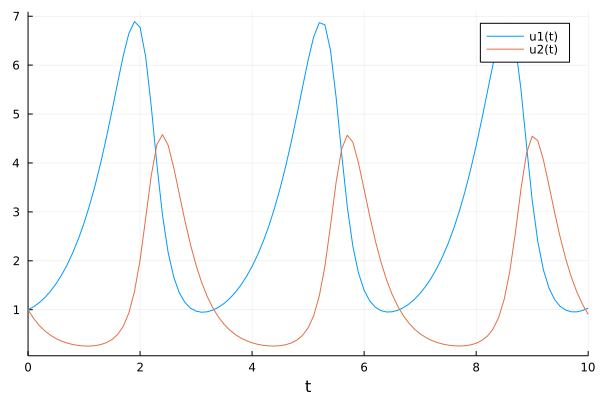

In [5]:
ode_sol = DifferentialEquations.solve(ode_prob, saveat=0.1)
Plots.plot(ode_sol)

# SciML - DiffEq within NeuralNet

Goal: We want to use Differential Equations as part of our Lux model. In other words, now the ODE shall become a Lux layer.

For Lux we need to define a custom type for our new layer.

In [6]:
struct ODELayer{ProblemType, AlgorithmType, KeywordArgumentsType} <: Lux.AbstractExplicitLayer
    prob::ProblemType
    alg::AlgorithmType
    kwargs::KeywordArgumentsType
end
ODELayer(prob, alg=DifferentialEquations.Tsit5(); kwargs...) = ODELayer(prob, alg, kwargs)

ODELayer

The key part is to define, how the model acts on data

In [22]:
"""
a custom lux model needs to be callable with exactly three arguments:
1. the input
2. the parameters (often abbriviated `ps`)
3. the states (often abbriviated `st`)
""" 
function (l::ODELayer)(input, parameters, states)
    # use new parameters
    pred = DifferentialEquations.solve(l.prob, l.alg; l.kwargs..., p=parameters)
    pred, states
end

ODELayer

The last todo is to specify initial parameters and states via a predefined Lux interface

In [14]:
function Lux.initialparameters(rng::Random.AbstractRNG, l::ODELayer)
    Random.rand!(rng, similar(l.prob.p))
end
Lux.initialstates(::Random.AbstractRNG, ::ODELayer) = NamedTuple()

Our Lux model is ready now

In [15]:
model = ODELayer(ode_prob, saveat=0.1)

ODELayer()          # 4 parameters

In [23]:
ps, st = Lux.setup(rng, model)

([0.9223171788742697, 0.040441694559945285, 0.5733819926662398, 0.9813641372820436], NamedTuple())

In [25]:
# we pass a dummy input ()
pred, st = Lux.apply(model, (), ps, st)
Array(pred)

2×101 Matrix{Float64}:
 1.0  1.09209  1.19242  1.30161  1.42032  …  0.0503101  0.0546317  0.059354
 1.0  1.04629  1.10511  1.17928  1.2726      2.49458    2.36773    2.24831

Let's define the loss function

In [18]:
data = Array(ode_sol)


2×101 Matrix{Float64}:
 1.0  1.06108   1.14403   1.24917   1.37764   …  0.956979  0.983561  1.03376
 1.0  0.821084  0.679053  0.566893  0.478813     1.35559   1.10629   0.90637

In [26]:
sum(abs2, Array(pred) - data)

188591.24402511283

In [28]:
"""
The function must take 4 inputs – model, parameters, states and data.
The function must return 3 values – loss, updated_state, and any computed statistics.

See https://lux.csail.mit.edu/dev/api/contrib/#Lux.Training.compute_gradients
"""
function loss_function(model, ps, st, data)
    pred, st = Lux.apply(model, (), ps, st)
    loss = sum(abs2, Array(pred) - data)  # compare them to being constant
    statistics = ()
    return loss, st, statistics
end

loss_function

In [29]:
loss_function(model, ps, st, data)

(188591.24402511283, NamedTuple(), ())

Let's train

In [48]:
@doc Lux.Training.TrainState

```
TrainState
```

Training State containing:

  * `model`: `Lux`` model.
  * `parameters`: Trainable Variables of the `model`.
  * `states`: Non-trainable Variables of the `model`.
  * `optimizer_state`: Optimizer State.
  * `step`: Number of updates of the parameters made.

```
TrainState(rng::Random.AbstractRNG, model::Lux.AbstractExplicitLayer,
           optimizer::Optimisers.AbstractRule; transform_variables::Function=Lux.cpu)
```

Constructor for `TrainState`.

## Arguments

  * `rng`: Random Number Generator.
  * `model`: `Lux` model.
  * `optimizer`: Optimizer from `Optimisers.jl`.
  * `transform_variables`: Function to transform the variables of the model. Typically used to transfer variables to `gpu`/`cpu`.

## Returns

`TrainState` object.


In [50]:
@less Lux.Training.TrainState(rng, model, opt)

module Training

# NOTE(@avik-pal): In the long term this will be pulled out into its own package but
# currently all the dependencies are met by Lux itself.
import ..Lux
import Optimisers, Random, Setfield, Zygote

"""
    TrainState

Training State containing:

  - `model`: `Lux`` model.
  - `parameters`: Trainable Variables of the `model`.
  - `states`: Non-trainable Variables of the `model`.
  - `optimizer_state`: Optimizer State.
  - `step`: Number of updates of the parameters made.
"""
struct TrainState{Ps, St, Ost, M}
    model::M
    parameters::Ps
    states::St
    optimizer_state::Ost
    step::Int
end

"""
    TrainState(rng::Random.AbstractRNG, model::Lux.AbstractExplicitLayer,
               optimizer::Optimisers.AbstractRule; transform_variables::Function=Lux.cpu)

Constructor for `TrainState`.

## Arguments

  - `rng`: Random Number Generator.
  - `model`: `Lux` model.
  - `optimizer`: Optimizer from `Optimisers.jl`.
  - `transform_variables`: Function to transform the 

stty: Standardeingabe: Inappropriate ioctl for device


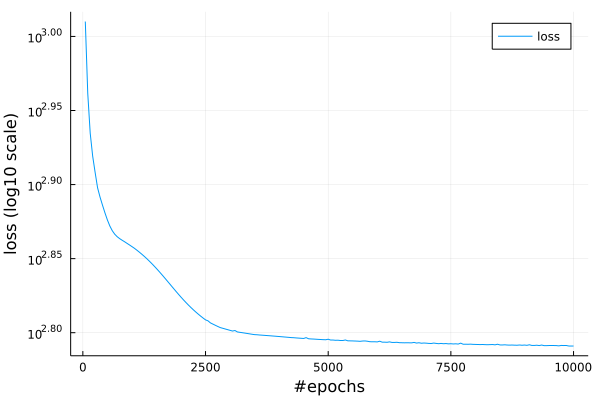

In [35]:
ad_backend = Lux.Training.ZygoteVJP()

opt = Optimisers.ADAM()
trainstate = Lux.Training.TrainState(rng, model, opt)

data = Array(ode_sol)
n_epochs = 10_000

losses = Float64[]
epochs = Int[]

for epoch in 1:n_epochs
    grads, loss, statistics, trainstate = Lux.Training.compute_gradients(
        ad_backend, loss_function, data, trainstate)

    if epoch % 50 == 0
        push!(losses, loss)
        push!(epochs, epoch)
        Plots.plot(epochs, losses, show = :inline, yscale = :log10,
            label = "loss", xlabel = "#epochs", ylabel="loss (log10 scale)")
    end
    
    if epoch == 5_000
        ps, st = Lux.setup(rng, model) .|> transform_variables
        st_opt = Optimisers.setup(Optimisers.(), ps)
        trainstate = Lux.Training.TrainState(
            trainstate.model,
            trainstate.parameters,
            trainstate.states,
            trainstate.
        )

    trainstate = Lux.Training.apply_gradients(trainstate, grads)
end

In [49]:
trainstate.optimizer_state

Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([-47.0884, 13.1207, -27.2123, 114.853], [2.72427e6, 5.09517e6, 1.3179e7, 5.35207e7], (6.0f-45, 4.5134f-5)))

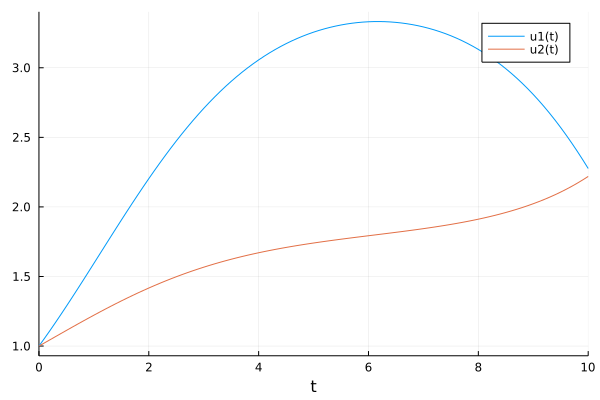

In [39]:
ode_pred, st = Lux.apply(trainstate.model, (), trainstate.parameters, trainstate.states)

Plots.plot(ode_pred)

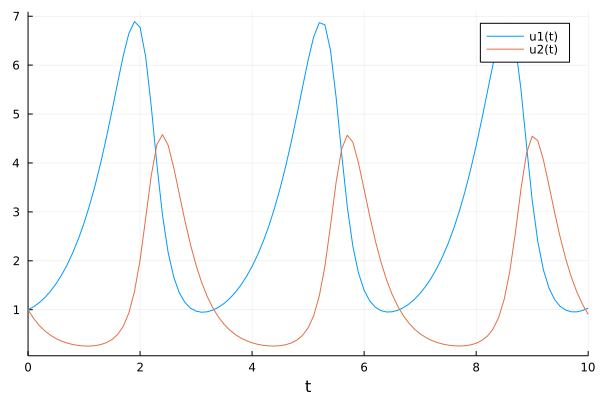

In [42]:
Plots.plot(ode_sol)

# SciML - NeuralNet within DiffEq

https://lux.csail.mit.edu/dev/examples/generated/intermediate/NeuralODE/main/